In [21]:
%%capture --no-stderr
%pip install -U langgraph langchain_anthropic langsmith langchain
# For the embedding-based classifier use in phase 2
%pip install -U sklearn langchain_openai
%pip install -U langchain-community

In [22]:
import pandas as pd
import numpy as np

df = pd.read_parquet("hf://datasets/urvog/llama2_transcripts_healthcare_callcenter/data/train-00000-of-00001-643ef6d7d804c522.parquet")

data = df.head(10)

In [23]:
import logging
import operator
from typing import Annotated, List, Optional, TypedDict, Sequence
from langchain_core.messages import BaseMessage

logging.basicConfig(level=logging.WARNING)
logger = logging.getLogger("health-chats")

class State(TypedDict):
    messages: Annotated[Sequence[BaseMessage], operator.add]
    prompt: Annotated[Sequence[BaseMessage], operator.add]
    pii_counter: int

In [35]:
def remove_PII_information(state: State):
    user_input = state['messages'][-1]
    prompt_1 = "Remove PII for me"
    prompt_2 = "This is the second prompt"
    
    if state['pii_counter'] is None:
        pii_counter = 0
        # Make the call here to the LLM using Prompt 1.
        return {"messages": ["PII returned"], "prompt": [prompt_2], "pii_counter": [pii_counter]}
        
    # This just says that PII node has been called N times
    pii_counter = int(state["pii_counter"][0]) + 1
    # Make the call here using prompt 2 to self correct.
    return {"messages": ["PII returned"], "prompt": [prompt_2], "pii_counter": [pii_counter]}


def should_continue(state: State):
    # Check if the thing ran, if so end, otherwise re run
    counter = int(state['pii_counter'][0])
    print(state)
    
    if counter == 3:
        return "writer"
    return "continue"

def writer(state: State):
    print("ending this shit")

from langgraph.graph import StateGraph, Graph, START, END

workflow = StateGraph(State)

workflow.add_node("pii_agent", remove_PII_information)
workflow.add_node("writer_agent", writer)
# workflow.add_edge("pii_agent", "writer_agent")
workflow.add_edge(START, "pii_agent")
workflow.add_edge("writer_agent", END)

workflow.add_conditional_edges(
    "pii_agent",
    should_continue,
    {
        "continue": "pii_agent",
        "writer" : "writer_agent"
    }
)

graph = workflow.compile()

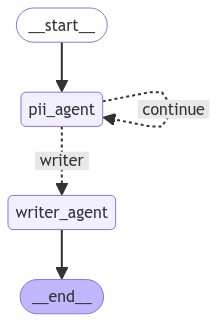

In [36]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception as e:
    print(e)
    # This requires some extra dependencies and is optional
    pass

In [37]:
input_text = "testing"

output = graph.invoke({"messages": [input_text]})

{'messages': ['testing', 'PII returned'], 'prompt': ['This is the second prompt'], 'pii_counter': [0]}
{'messages': ['testing', 'PII returned', 'PII returned'], 'prompt': ['This is the second prompt', 'This is the second prompt'], 'pii_counter': [1]}
{'messages': ['testing', 'PII returned', 'PII returned', 'PII returned'], 'prompt': ['This is the second prompt', 'This is the second prompt', 'This is the second prompt'], 'pii_counter': [2]}
{'messages': ['testing', 'PII returned', 'PII returned', 'PII returned', 'PII returned'], 'prompt': ['This is the second prompt', 'This is the second prompt', 'This is the second prompt', 'This is the second prompt'], 'pii_counter': [3]}
ending this shit
